In [3]:
# To train a 300d embedding for the charactors in 
import tensorflow as tf
import numpy as np
import pandas as pd
from Input import InputData 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
#skip-gram parameters 
# dimension of the embedded vector
embedding_size = 300
data_path = './data/QuanTangShi.txt'



In [5]:
# use NCE https://mk-minchul.github.io/NCE/
# how to use optimizer https://gist.github.com/DominicBreuker/c1082d02456c4186c1a5f77e12972b85
class Word2Vec(object):
    def __init__(self, data_path, embedding_size):
        
        self.data = InputData(data_path, 10000)
        self.batch_size = 1024
        self.vocab_size = self.data.word_count
        self.num_sampled = 5
        self.window_size = 5
        self.learning_rate = 0.025
        
        
        center_words = tf.placeholder(tf.int32, shape = [self.batch_size])
        target_words = tf.placeholder(tf.int32, shape= [self.batch_size, 1])

        embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embed_matrix, center_words)
        
        nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, embedding_size], stddev=1.0 / embedding_size ** 0.5))
        nce_bias = tf.Variable(tf.zeros([self.vocab_size]))

        loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                             biases=nce_bias,
                                             labels=target_words,
                                             inputs=embed,
                                             num_sampled=self.num_sampled,
                                             num_classes=self.vocab_size))
        
  
        global_step = tf.Variable(0, name='global_step', trainable=False)
        
        self.center_words_placeholder = center_words
        self.target_words_placeholder = target_words
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(loss, global_step=global_step)
        self.loss = loss
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keepdims=True))
        self.normalized_embeddings = embed_matrix / norm
        
  
    def train_epoch(self, sess):
        pos_pairs = self.data.get_batch_pairs(self.batch_size, self.window_size)
        center_words = [pair[0] for pair in pos_pairs]
        target_words = [[pair[1]] for pair in pos_pairs]
        
        
        feed_dict = {
            self.center_words_placeholder: center_words,
            self.target_words_placeholder: target_words,
        }
        
        _, loss_value = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
        
        return loss_value
        

In [6]:
word2vec = Word2Vec(data_path, 300)

Total Lines:  42974
Vocab size: 7524
Corpus Length: 2602124


Loss: 19.08561516: 100%|██████████| 21/21 [00:01<00:00, 18.11it/s]


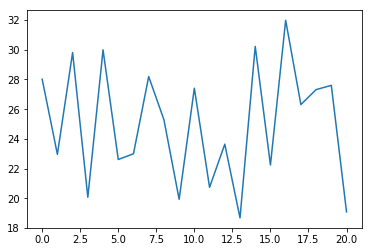

In [7]:
iteration = 0.001
pair_count = word2vec.data.evaluate_pair_count(word2vec.window_size)
batch_count = iteration * pair_count / word2vec.batch_size

process_bar = tqdm(range(int(batch_count)))

losses = []
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in process_bar:
        loss = word2vec.train_epoch(sess)
        process_bar.set_description("Loss: %0.8f" %loss)
        losses.append(loss)
        
    final_embedding = word2vec.normalized_embeddings.eval()

        
        
xs = list(range(len(losses)))

plt.plot(xs, losses)



In [19]:
import pandas as pd

final_embedding



labels = [word2vec.data.id2word[i] for i in range(len(word2vec.data.id2word))]


df = pd.DataFrame(data=final_embedding,    
                  index=labels,   
                  columns=list(range(1,301))) 

df.to_csv("embedding.csv")

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(final_embedding)


KeyboardInterrupt: 

In [10]:
from matplotlib.font_manager import FontProperties
ChineseFont = FontProperties(fname = '/home/jbai/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')


labels = [word2vec.data.id2word[i] for i in range(len(word2vec.data.id2word))]
# print(labels)

number_of_showing = 30

x_coords = Y[:number_of_showing, 0]
y_coords = Y[:number_of_showing, 1]
showed_labels = labels[:number_of_showing]
    # display scatter plot
    
    
plt.figure(figsize=(20,10))
plt.scatter(x_coords, y_coords)

for label, x, y in zip(labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', fontproperties = ChineseFont)
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

NameError: name 'Y' is not defined